## Config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

## Data

### Actual and TimeGPT forecats

In [2]:
df_train = pd.read_parquet('M3_yearly_processed.parquet')
df_eval = pd.read_parquet('M3_yearly_simple_forecasts.parquet')

### Other methods used in competition

In [3]:
def read_all_sheets(excel_path):
    """
    Reads all sheets from an Excel file and combines them into a single DataFrame.
    
    Args:
    - excel_path (str): The path to the Excel file.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the combined data from all sheets.
    """
    # Use pandas to read the Excel file and get sheet names
    xls = pd.ExcelFile(excel_path)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Iterate over all sheet names
    for sheet_name in xls.sheet_names:
        # Read the current sheet into a DataFrame
        df = pd.read_excel(xls, sheet_name=sheet_name, header=None)
        
        # Optionally, add a column to indicate the source sheet, if needed
        df['Sheet'] = sheet_name
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list into one
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df

excel_path = '/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/M-Competitions/M3-Competition/M3Forecast.xls'
combined_df = read_all_sheets(excel_path)
# Rename columns
combined_df.rename(columns = {0 : 'Series', 1 : 'NF'}, inplace = True)

# Change series to int in the same fashion as the other dataframes
combined_df['Series'] = combined_df['Series'].str.replace('N', '')
combined_df['Series'] = combined_df['Series'].str.replace(' ', '')
combined_df['Series'] = combined_df['Series'].astype(int)
# Only yearly data for this evaluation
combined_df = combined_df.loc[combined_df['Series'] <= 645].copy()
# Drop not necessary columns
cols_to_drop = list(range(8, 19+1))
combined_df.drop(columns = cols_to_drop, inplace = True)

In [4]:
# Change position of sheet column
cols = combined_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
combined_df = combined_df[cols]

# Rename columns so that 1 is the first forecast period
combined_df.rename(columns=lambda x: x - 1 if isinstance(x, int) else x, inplace=True)

# Melt the dataframe i.e. unpivot
df_long = pd.melt(combined_df, id_vars=['Sheet', 'NF' , 'Series'], value_name='value', var_name='ForecastPeriod')   

# Sort the dataframe
df_long = df_long.sort_values(by=['Sheet', 'Series', 'ForecastPeriod']).copy()

## Official Evaluation Metrics
Five accuracy measures:
1. Symmetric MAPE

2. Average Ranking

3. Median symmetric APE

4. Median RAE

5. RMSE (root mean squared error)

Forecasting metrics calculations with assist of github repository:
https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9

In [5]:
%run '/Users/tomaltenborg/Documents/Master/Master thesis/Notebooks/forecasting_metrics.py'

#### NB! When using methods from this file nothing is multiplied with 100 for percentage operations!

## Evaluation

### First group all data together in one dataframe
Make sure it is correctly sorted! 

In [6]:
grouped_df = pd.merge(df_train, df_eval, on = ['Series', 'Date'], how = 'left')
grouped_df.dropna(subset = 'TimeGPT', inplace = True)

In [7]:
# Add forecast period column to replace dates and prepare for merging
grouped_df = grouped_df.groupby('Series').apply(lambda x: x.nlargest(6, 'Date')).reset_index(drop=True).copy()

<ipython-input-7-f8af0542ec1b>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = grouped_df.groupby('Series').apply(lambda x: x.nlargest(6, 'Date')).reset_index(drop=True).copy()


In [8]:
### IMPORTANT ###
# Resort the dataframe to ensure correct evaluation
grouped_df = grouped_df.sort_values(by = ['Series', 'Date', 'Category']).copy()
grouped_df['ForecastPeriod'] = grouped_df.groupby('Series').cumcount() + 1

In [9]:
final_df = pd.merge(grouped_df, df_long, on = ['Series', 'ForecastPeriod'], how = 'left')
# Drop not necessary columns
final_df.drop(columns = ['NF_x', 'N', 'NF_y', 'Date'], inplace = True)
final_df.rename(columns = {'Value' : 'Actual', 'value' : 'Forecast', 'Sheet' : 'Method'}, inplace = True)
final_df.sort_values(by = ['Series', 'ForecastPeriod'], inplace = True)

In [10]:
timegpt_df = final_df.copy()
timegpt_df['Forecast'] = timegpt_df['TimeGPT']

# Step 2: Update the Method column
timegpt_df['Method'] = 'TimeGPT'

# Optional: If you want to remove original TimeGPT rows from the original df
# You might skip this step if you want to keep both Forecast and TimeGPT as separate methods
df = final_df.drop(columns=['TimeGPT'])

# Step 3: Concatenate the modified TimeGPT dataframe with the original dataframe
updated_df = pd.concat([df, timegpt_df])

In [11]:
updated_df.sort_values(by = ['Series', 'ForecastPeriod'], inplace = True)
updated_df.drop(columns = 'TimeGPT', inplace = True)
updated_df.drop_duplicates(inplace= True)

In [12]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89010 entries, 0 to 85118
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Series          89010 non-null  int64  
 1   Category        89010 non-null  object 
 2   Actual          89010 non-null  float64
 3   ForecastPeriod  89010 non-null  object 
 4   Method          89010 non-null  object 
 5   Forecast        89010 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.8+ MB


#### Function that returns all eval metrics specified in competition

In [13]:
# Näive2 is used as the benchmark for calculating the MdRAE
benchmark = updated_df.loc[updated_df['Method'] == 'NAIVE2'].copy()
benchmark

,Series,Category,Actual,ForecastPeriod,Method,Forecast
13,1,MICRO,5379.75,1,NAIVE2,4936.99
35,1,MICRO,6158.68,2,NAIVE2,4936.99
57,1,MICRO,6876.58,3,NAIVE2,4936.99
79,1,MICRO,7851.91,4,NAIVE2,4936.99
101,1,MICRO,8407.84,5,NAIVE2,4936.99
...,...,...,...,...,...,...
85043,645,OTHER,7343.00,2,NAIVE2,6115.00
85065,645,OTHER,5730.00,3,NAIVE2,6115.00
85087,645,OTHER,5007.00,4,NAIVE2,6115.00
85109,645,OTHER,4715.00,5,NAIVE2,6115.00


In [14]:
# Calculate the sMAPE, sMDAPE, RMSE and MdRAE for each series, category, method and forecast period
full_results = []
for (series, category, method, period), group in updated_df.groupby(['Series', 'Category', 'Method', 'ForecastPeriod']):
    actual = np.array(group['Actual'].values)
    forecast = np.array(group['Forecast'].values)

    smape_value = smape(actual, forecast)
    smdape_val = smdape(actual, forecast)
    rmse_val = rmse(actual, forecast)

    benchmark_group = benchmark[(benchmark['Series'] == series) & (benchmark['ForecastPeriod'] == period)]
    benchmark_forecast = np.array(benchmark_group['Forecast'].values)
    
    # Calculate MDRAE using the benchmark forecast
    # If the benchmark forecast is 0, the MDRAE is set to 100
    # Perhaps not the best solution, but does ensure no absurd values and imporves readability and plotting 
    # Main thing about MdRAE is that if it is greater than 1 the forecast is worse than the benchmark
    if actual == benchmark_forecast:
        mdrae_val = 100
    else:
        mdrae_val = mdrae(actual, forecast, benchmark_forecast)

    full_results.append({
        'Series': series,
        'Category': category,
        'Method': method,
        'ForecastPeriod': period,
        'sMAPE': smape_value,
        'sMDAPE': smdape_val,
        'MDRAE': mdrae_val,
        'RMSE': rmse_val
    })

full_results_df = pd.DataFrame(full_results)

full_results_df.reset_index(inplace = True, drop = True)


In [15]:
print(len(full_results_df))
print(full_results_df['MDRAE'].isna().sum())

89010
0


In [16]:
print(full_results_df.loc[(full_results_df['Method'] == 'ARARMA') &
                     (full_results_df['ForecastPeriod'] == 6)]['sMAPE'].mean())
### Works! ###

0.2570317110784237


In [18]:
# ### Save yearly results to parquet for merging with other frequencies
# full_results_df.to_parquet('M3_yearly_results.parquet', compression='snappy', engine='pyarrow')

#### Comment on Median Relative Absolute Error and Median Symmetric Absolute Percentage Error 
##### MdRAE
Instances where the actual value and benchmark value are equal causes absurd numbers where the readability and visualizing is hindered. To leviate this issue to some extent, if it is the case that the actual and benchmark are equal than the MdRAE is set to 100 else it is calculated normally. 

##### Median Symmetric APE 
It seems senseless to calculate for each forecast step and is metric that is only suited for entire series and not individual forecasts steps as it then just becomes equal to the SMAPE

### Plots of different evaluation metrics

#### RMSE

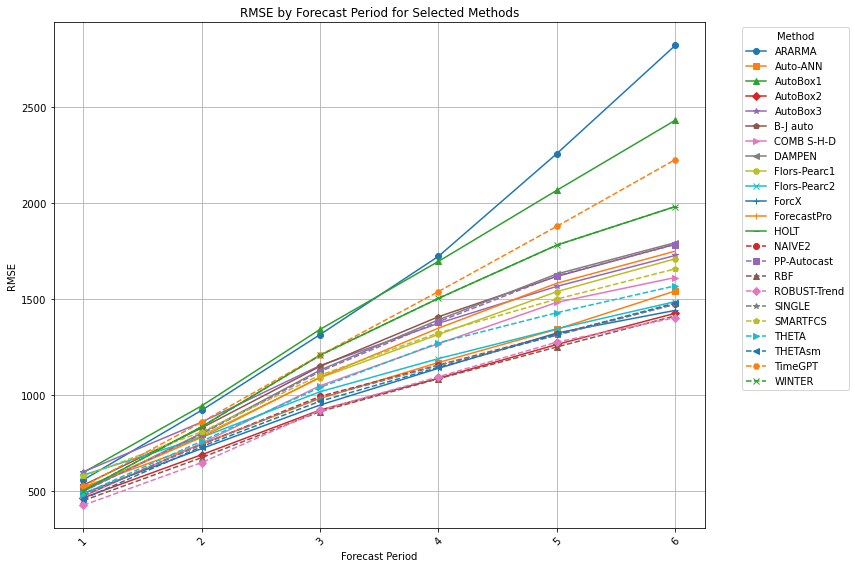

In [167]:
methods = full_results_df['Method'].unique().tolist()

# Filter the DataFrame to only include the specified methods
filtered_df = full_results_df[results_df['Method'].isin(methods)]
# Group by 'ForecastPeriod' and 'Method' and calculate the mean 'sMAPE'
agg_df = filtered_df.groupby(['ForecastPeriod', 'Method'])['RMSE'].mean().reset_index()

# Pivot the aggregated DataFrame
pivot_df = agg_df.pivot(index='ForecastPeriod', columns='Method', values='RMSE')
# Define a list of markers and line styles
markers = ['o', 's', '^', 'D', '*', 'p', '>', '<', 'H', 'x', '+', '|', '_']
line_styles = ['-', '--', '-.', ':']

# Create a cycle of line styles and markers
style_cycler = cycle([(line_style, marker) for line_style in line_styles for marker in markers])

# Plotting with different line styles and markers
plt.figure(figsize=(12, 8))

for method, style in zip(pivot_df.columns, style_cycler):
    line_style, marker = style
    plt.plot(pivot_df.index, pivot_df[method], label=method, linestyle=line_style, marker=marker)

plt.xlabel('Forecast Period')
plt.ylabel('RMSE')
plt.title('RMSE by Forecast Period for Selected Methods')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

#### Symmetric Median APE (Absolute percentage error)

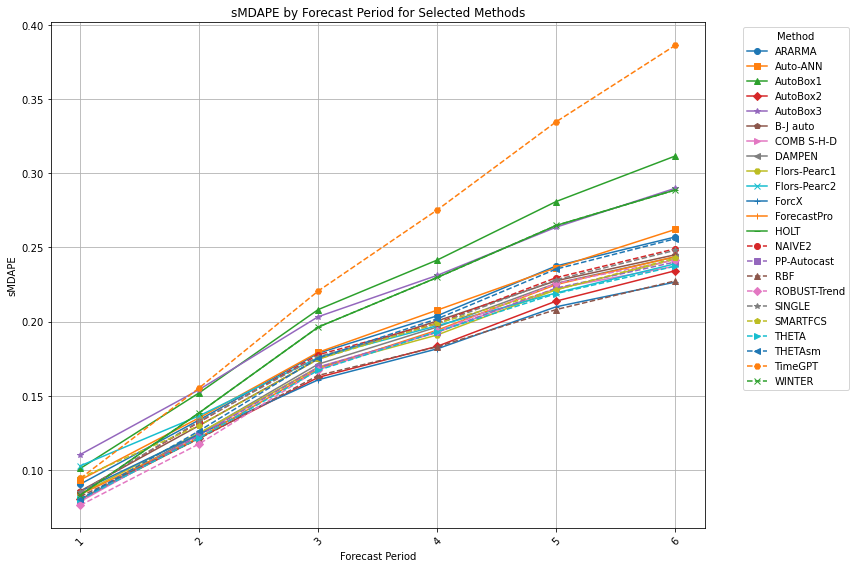

In [168]:
methods = full_results_df['Method'].unique().tolist()

# Filter the DataFrame to only include the specified methods
filtered_df = full_results_df[results_df['Method'].isin(methods)]
# Group by 'ForecastPeriod' and 'Method' and calculate the mean 'sMAPE'
agg_df = filtered_df.groupby(['ForecastPeriod', 'Method'])['sMDAPE'].mean().reset_index()

# Pivot the aggregated DataFrame
pivot_df = agg_df.pivot(index='ForecastPeriod', columns='Method', values='sMDAPE')
# Define a list of markers and line styles
markers = ['o', 's', '^', 'D', '*', 'p', '>', '<', 'H', 'x', '+', '|', '_']
line_styles = ['-', '--', '-.', ':']

# Create a cycle of line styles and markers
style_cycler = cycle([(line_style, marker) for line_style in line_styles for marker in markers])

# Plotting with different line styles and markers
plt.figure(figsize=(12, 8))

for method, style in zip(pivot_df.columns, style_cycler):
    line_style, marker = style
    plt.plot(pivot_df.index, pivot_df[method], label=method, linestyle=line_style, marker=marker)

plt.xlabel('Forecast Period')
plt.ylabel('sMDAPE')
plt.title('sMDAPE by Forecast Period for Selected Methods')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

#### sMAPE (Symmetric Mean Absolute Percentage Error)

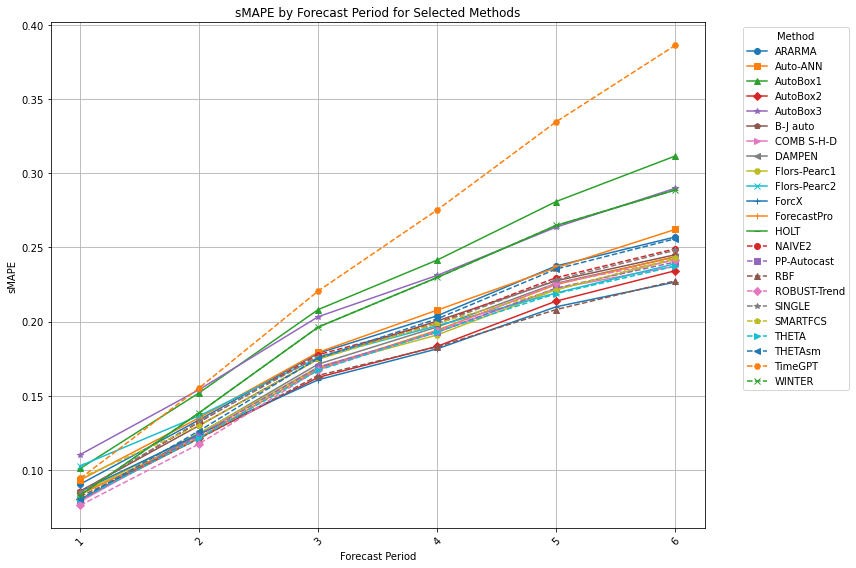

In [169]:
methods = full_results_df['Method'].unique().tolist()

# Filter the DataFrame to only include the specified methods
filtered_df = full_results_df[results_df['Method'].isin(methods)]
# Group by 'ForecastPeriod' and 'Method' and calculate the mean 'sMAPE'
agg_df = filtered_df.groupby(['ForecastPeriod', 'Method'])['sMAPE'].mean().reset_index()

# Pivot the aggregated DataFrame
pivot_df = agg_df.pivot(index='ForecastPeriod', columns='Method', values='sMAPE')
# Define a list of markers and line styles
markers = ['o', 's', '^', 'D', '*', 'p', '>', '<', 'H', 'x', '+', '|', '_']
line_styles = ['-', '--', '-.', ':']

# Create a cycle of line styles and markers
style_cycler = cycle([(line_style, marker) for line_style in line_styles for marker in markers])

# Plotting with different line styles and markers
plt.figure(figsize=(12, 8))

for method, style in zip(pivot_df.columns, style_cycler):
    line_style, marker = style
    plt.plot(pivot_df.index, pivot_df[method], label=method, linestyle=line_style, marker=marker)

plt.xlabel('Forecast Period')
plt.ylabel('sMAPE')
plt.title('sMAPE by Forecast Period for Selected Methods')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

#### mdRAE (Median Relative Absolute Error)

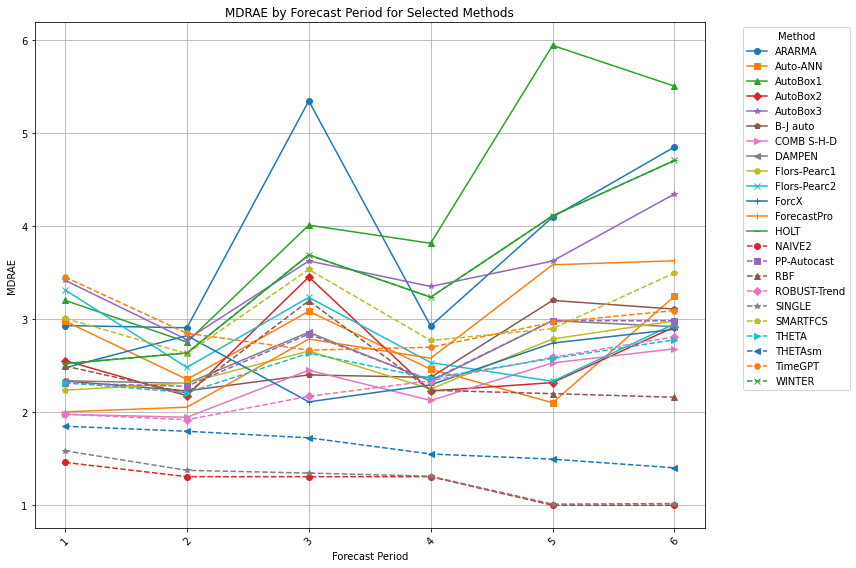

In [170]:
methods = full_results_df['Method'].unique().tolist()

# Filter the DataFrame to only include the specified methods
filtered_df = full_results_df[results_df['Method'].isin(methods)]
# Group by 'ForecastPeriod' and 'Method' and calculate the mean 'sMAPE'
agg_df = filtered_df.groupby(['ForecastPeriod', 'Method'])['MDRAE'].mean().reset_index()

# Pivot the aggregated DataFrame
pivot_df = agg_df.pivot(index='ForecastPeriod', columns='Method', values='MDRAE')
# Define a list of markers and line styles
markers = ['o', 's', '^', 'D', '*', 'p', '>', '<', 'H', 'x', '+', '|', '_']
line_styles = ['-', '--', '-.', ':']

# Create a cycle of line styles and markers
style_cycler = cycle([(line_style, marker) for line_style in line_styles for marker in markers])

# Plotting with different line styles and markers
plt.figure(figsize=(12, 8))

for method, style in zip(pivot_df.columns, style_cycler):
    line_style, marker = style
    plt.plot(pivot_df.index, pivot_df[method], label=method, linestyle=line_style, marker=marker)

plt.xlabel('Forecast Period')
plt.ylabel('MDRAE')
plt.title('MDRAE by Forecast Period for Selected Methods')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ticklabel_format(useOffset=False, style='plain')
plt.grid(True)
plt.show()

### Combined plot

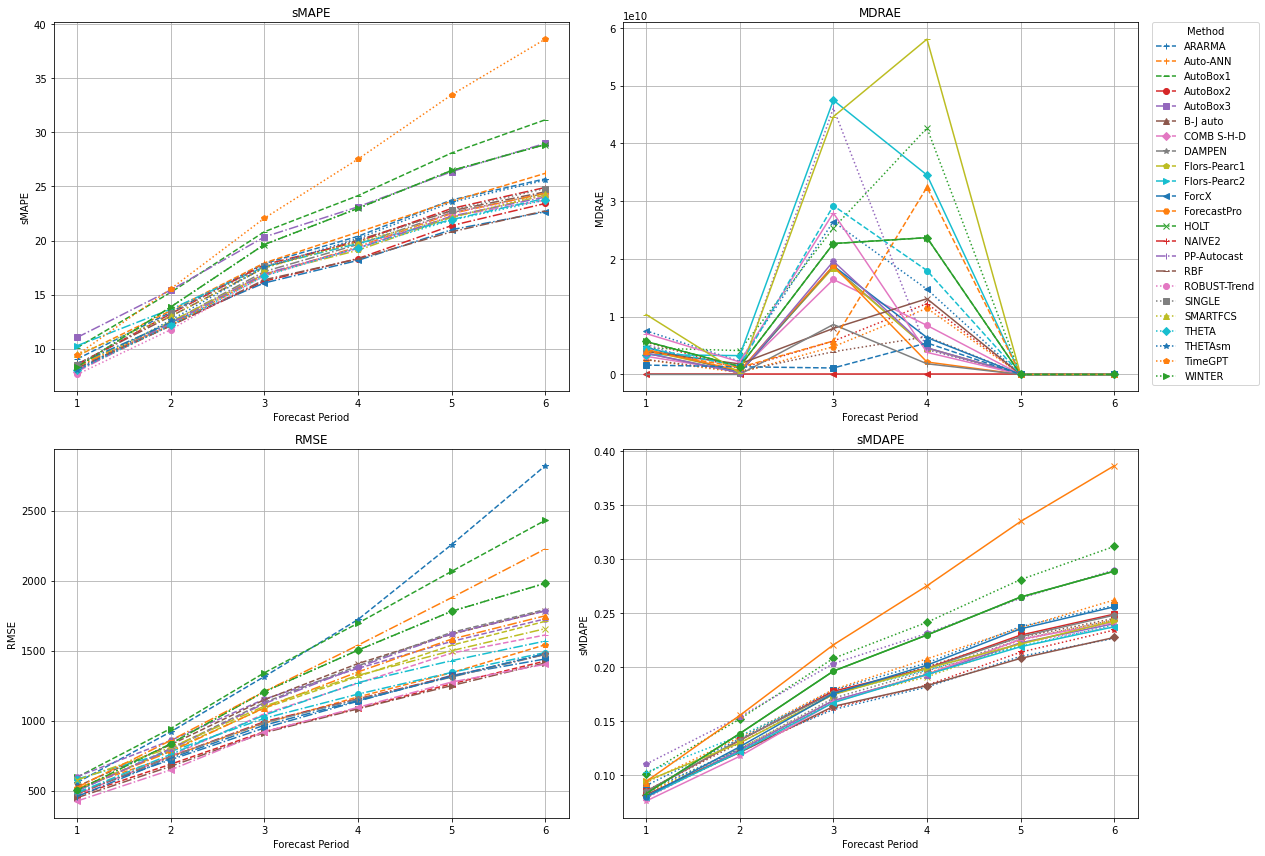

In [38]:
# Define the metrics to plot
metrics = ['sMAPE', 'MDRAE', 'RMSE', 'sMDAPE']

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()  # Flatten the array for easy indexing

# Collect legend handles and labels
handles, labels = [], []

for i, metric in enumerate(metrics):
    # Group and aggregate the data for the current metric
    agg_df = filtered_df.groupby(['ForecastPeriod', 'Method'])[metric].mean().reset_index()
    pivot_df = agg_df.pivot(index='ForecastPeriod', columns='Method', values=metric)

    for method, style in zip(pivot_df.columns, cycle(style_cycler)):
        line_style, marker = style
        line, = axs[i].plot(pivot_df.index, pivot_df[method], label=method, linestyle=line_style, marker=marker)
        if i == 0:  # Only add to legend for the first metric
            handles.append(line)
            labels.append(method)

    axs[i].set_title(metric)
    axs[i].set_xlabel('Forecast Period')
    axs[i].set_ylabel(metric)
    axs[i].grid(True)

# Add a single legend outside the right side of the subplots
fig.legend(handles, labels, title='Method', loc='upper right', bbox_to_anchor=(1.1, 0.975))

plt.tight_layout()
plt.show()
